**Data of HSE publishing from SCOPUS database. 
I used data of 2017-2021 period. I analyze the Titles of published researches**



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install -q pyspark==3.2.0 spark-nlp

     |████████████████████████████████| 281.3 MB 40 kB/s 
     |████████████████████████████████| 142 kB 64.4 MB/s 
     |████████████████████████████████| 198 kB 39.5 MB/s 


In [3]:
!pip install findspark

In [4]:
import sparknlp

spark = sparknlp.start(spark32 = True)

from sparknlp.base import *
from sparknlp.annotator import *

from pyspark.ml import Pipeline

print("Spark NLP version", sparknlp.version())

print("Apache Spark version:", spark.version)

spark

Spark NLP version 3.4.2
Apache Spark version: 3.2.0


In [5]:
import sys
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover
from pyspark.sql.types import IntegerType
import os
import pandas as pd
import numpy as np
from operator import add
from pyspark.ml.feature import Tokenizer
import pyspark.sql.functions as f
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import glob
from pyspark.sql.functions import *
import warnings
warnings.filterwarnings('ignore')

In [6]:
spark = SparkSession\
  .builder \
  .appName("WordCounter") \
  .getOrCreate()

**Analyzying of all csv-files**

In [7]:
!git clone https://github.com/IlonaInch/research_seminar.git

Cloning into 'research_seminar'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 42 (delta 15), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (42/42), done.


In [8]:
path = ('/content/research_seminar')
all_files = glob.glob(os.path.join(path, "scopus*.csv"))
all_files

['/content/research_seminar/scopus_2018_article.csv',
 '/content/research_seminar/scopus_2019_allOpenAccess.csv',
 '/content/research_seminar/scopus_2021_AllOpenAccess.csv',
 '/content/research_seminar/scopus_2018_conferencePaper.csv',
 '/content/research_seminar/scopus_2017.csv',
 '/content/research_seminar/scopus_2020_except_AllOpenAccess.csv',
 '/content/research_seminar/scopus_2020_allOpenAccess.csv',
 '/content/research_seminar/scopus_2021_except_AllOpenAccess.csv',
 '/content/research_seminar/scopus_2019_except_allOpenAccess.csv']

In [9]:
data = spark.read.format('csv').options(header='true', inferSchema='true').load(all_files)
data.show(10)

+--------------------+------------------------+--------------------+----+--------------------+----+-------+--------+---------------+------------------+------------------+-----------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------+------------------------+---------------------------------------+-----------------------+----------------------+-------------+-------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+------------------------+-------------------------+--------------------+-------------------------+---------+--------+--------------------+--------------------+----------------+----------------------------+---------------+--------+----+-----+--------------------+----------------------------+------------------------------+-------------+---

In [10]:
name_keywords_eid = data[["Авторы", "Название","Ключевые слова автора"]]
new_data =name_keywords_eid
new_data.show(10)

+--------------------+--------------------+---------------------+
|              Авторы|            Название|Ключевые слова автора|
+--------------------+--------------------+---------------------+
|          Gurvich V.|Balanced flows fo...| Balanced flow; Ca...|
|       Belenkov V.E.|DO INTERNET PENET...| Civil society org...|
|Kazun A.D., Porsh...|WHO BELIEVES in C...| Conspiracy theori...|
|Klimova A.M., Kul...|THE ROLE of SOCIA...| Ecological protes...|
|Babayan V.V., Tur...|NOT UNIQUE, NOT U...| Internet; Interne...|
|Poretskova A.A., ...|MEMES AS CONSOLID...| Memes; New media;...|
|Sokolov B.O., Zav...|SOCIO-DEMOGRAPHIC...| Conspiracy theori...|
|Petrov A.P.Ch., A...|IS NETWORK STRUCT...| Agent-oriented mo...|
|Akhremenko A.S., ...|IMPACT OF NEW INF...| Civic participati...|
|Jakobson L.I., Iv...|NGO CORPORATE GOV...| Board of director...|
+--------------------+--------------------+---------------------+
only showing top 10 rows



In [12]:
new_data = new_data.withColumnRenamed('Название','Name')
new_data.show(10)

+--------------------+--------------------+---------------------+
|              Авторы|                Name|Ключевые слова автора|
+--------------------+--------------------+---------------------+
|          Gurvich V.|Balanced flows fo...| Balanced flow; Ca...|
|       Belenkov V.E.|DO INTERNET PENET...| Civil society org...|
|Kazun A.D., Porsh...|WHO BELIEVES in C...| Conspiracy theori...|
|Klimova A.M., Kul...|THE ROLE of SOCIA...| Ecological protes...|
|Babayan V.V., Tur...|NOT UNIQUE, NOT U...| Internet; Interne...|
|Poretskova A.A., ...|MEMES AS CONSOLID...| Memes; New media;...|
|Sokolov B.O., Zav...|SOCIO-DEMOGRAPHIC...| Conspiracy theori...|
|Petrov A.P.Ch., A...|IS NETWORK STRUCT...| Agent-oriented mo...|
|Akhremenko A.S., ...|IMPACT OF NEW INF...| Civic participati...|
|Jakobson L.I., Iv...|NGO CORPORATE GOV...| Board of director...|
+--------------------+--------------------+---------------------+
only showing top 10 rows



**There are many columns, but I will find most common words from "Название" column**

In [13]:
new_data.withColumn('word', f.explode(f.split(f.col('Name'), ' '))) \
  .groupBy('word') \
  .count() \
  .sort('count', ascending=False) \
  .show(10)

+----+-----+
|word|count|
+----+-----+
|  of|10891|
| the| 6386|
| and| 5501|
|  in| 5472|
| for| 2332|
|   a| 1879|
| The| 1609|
|  on| 1463|
|with| 1179|
|  to| 1177|
+----+-----+
only showing top 10 rows



In [14]:
new_data=new_data.na.drop()

In [15]:
new_data.show(10)

+--------------------+--------------------+---------------------+
|              Авторы|                Name|Ключевые слова автора|
+--------------------+--------------------+---------------------+
|          Gurvich V.|Balanced flows fo...| Balanced flow; Ca...|
|       Belenkov V.E.|DO INTERNET PENET...| Civil society org...|
|Kazun A.D., Porsh...|WHO BELIEVES in C...| Conspiracy theori...|
|Klimova A.M., Kul...|THE ROLE of SOCIA...| Ecological protes...|
|Babayan V.V., Tur...|NOT UNIQUE, NOT U...| Internet; Interne...|
|Poretskova A.A., ...|MEMES AS CONSOLID...| Memes; New media;...|
|Sokolov B.O., Zav...|SOCIO-DEMOGRAPHIC...| Conspiracy theori...|
|Petrov A.P.Ch., A...|IS NETWORK STRUCT...| Agent-oriented mo...|
|Akhremenko A.S., ...|IMPACT OF NEW INF...| Civic participati...|
|Jakobson L.I., Iv...|NGO CORPORATE GOV...| Board of director...|
+--------------------+--------------------+---------------------+
only showing top 10 rows



In [16]:
tokenizer = Tokenizer(inputCol="Name", outputCol="words_token")
tokenized = tokenizer.transform(new_data).select('Name','words_token')
tokenized.show(truncate=40)
remover = StopWordsRemover(inputCol='words_token', outputCol='words_clean')
data_clean = remover.transform(tokenized).select('Name', 'words_clean')
data_clean.show(truncate=40)

+----------------------------------------+----------------------------------------+
|                                    Name|                             words_token|
+----------------------------------------+----------------------------------------+
|Balanced flows for transshipment prob...|[balanced, flows, for, transshipment,...|
|DO INTERNET PENETRATION and ONLINE CE...|[do, internet, penetration, and, onli...|
|WHO BELIEVES in CONSPIRACY THEORIES? ...|[who, believes, in, conspiracy, theor...|
|THE ROLE of SOCIAL MEDIA in SHAPING R...|[the, role, of, social, media, in, sh...|
|NOT UNIQUE, NOT UNIVERSAL: RISK PERCE...|[not, unique,, not, universal:, risk,...|
|MEMES AS CONSOLIDATION TOOL of the PR...|[memes, as, consolidation, tool, of, ...|
|SOCIO-DEMOGRAPHIC PROFILES, PERSONALI...|[socio-demographic, profiles,, person...|
|IS NETWORK STRUCTURE IMPORTANT FOR PR...|[is, network, structure, important, f...|
|IMPACT OF NEW INFORMATION AND COMMUNI...|[impact, of, new, information, and

In [17]:
most_common = data_clean.withColumn('word', f.explode(f.col('words_clean'))) \
  .groupBy('word') \
  .count().sort('count', ascending=False)

In [18]:
most_common.show(20)

+-----------+-----+
|       word|count|
+-----------+-----+
|    russian|  969|
|     russia|  493|
|   analysis|  450|
|          в|  408|
|          и|  386|
|     social|  319|
|      model|  310|
|      study|  285|
|development|  271|
|       case|  264|
|     system|  263|
|      based|  247|
|      using|  241|
|        new|  239|
|           |  229|
|       data|  213|
|   evidence|  201|
|    systems|  187|
|   economic|  179|
|   approach|  175|
+-----------+-----+
only showing top 20 rows



In [19]:
pd_df = spark.createDataFrame(most_common.take(10)).toPandas()

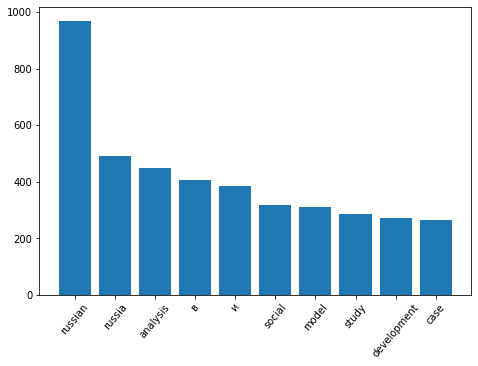

In [20]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(pd_df['word'],pd_df['count'])
plt.xticks(rotation=50)
stopwords = set(STOPWORDS)
plt.show(10)